In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
import time
import gc
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Loading Data

In [ ]:
s = time.time()

train_vid_names = []
train_vid_label = []

train_csv = open('/content/drive/MyDrive/assign2/train.csv')
reader = csv.DictReader(train_csv)

for row in reader:
    train_vid_names.append(row['File'])
    train_vid_label.append([1,0] if row['True_Label']=='fire' else [0,1])
    
train_csv.close()
train_vid_label = np.array(train_vid_label)

e = time.time()
print(e-s)
gc.collect()

0.254680871963501


185

In [ ]:
max_frames = 100
frame_size = (128, 128)

frames = np.zeros((len(train_vid_names), max_frames, frame_size[0], frame_size[1], 3), dtype=np.float32)
frame_count = []
train_folder = '/content/drive/MyDrive/assign2/train/'

print(sys.getsizeof(frames))

s = time.time()

for i in tqdm(range(len(train_vid_names))):
    
    vid = cv2.VideoCapture(train_folder+train_vid_names[i])
    
    # Load full video in temp
    temp = [] 
    ret, frame = vid.read()
    while ret:
        temp.append(cv2.resize(frame,frame_size))
        ret, frame = vid.read()
     
    length = len(temp)
    if length < max_frames:
        pads_required = max_frames % length
        each_frame_multiplicity = max_frames // length
        for _ in range(len(temp)):
            for __ in range(each_frame_multiplicity):
                frames[i][pads_required + _*each_frame_multiplicity + __] = temp[_]
    else:
        jump = length / max_frames
        for _ in range(max_frames):
            frames[i][_] = temp[int(_*jump)]

    frame_count.append(frames[i].shape)

e = time.time()
print(e-s)
gc.collect()

2359296160


  0%|          | 0/120 [00:00<?, ?it/s]

251.8428087234497


19

# Normalization

In [ ]:
# means = []
# stds = []
# for i in range(3):
#   means.append(np.mean(frames[:,:,:,:,i]))
#   stds.append(np.std(frames[:, :, :, :, i]))

In [ ]:
# means = np.asarray(means).reshape(1, 1, 1, 1, -1)
# means.shape

In [ ]:
# mean = np.mean(frames, axis=-1).reshape([*frames.shape[:-1], 1])
# mean = np.mean(frames, axis=-1).reshape
# std = np.std(frames, axis=-1).reshape([*frames.shape[:-1], 1])
# 
# frames = (frames - mean) / (1e-5 + std)

# The Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

gpus = tf.config.experimental.list_physical_devices('GPU')
for i in gpus:
    print(i)
    tf.config.experimental.set_memory_growth(i, True)

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape = (max_frames, frame_size[0], frame_size[1], 3)))

model.add(layers.TimeDistributed(layers.Conv2D(16,(3,3),activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D()))

model.add(layers.TimeDistributed(layers.Conv2D(32,(3,3),activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D()))

model.add(layers.TimeDistributed(layers.Reshape((-1,))))

model.add(layers.GRU(16, return_sequences=True))
model.add(layers.GRU(32, return_sequences=False))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
# model.add(layers.Dense(256, activation = 'relu',kernel_regularizer=tf.keras.regularizers.L2(0)))
# model.add(layers.Dropout(0.05))
# model.add(layers.Dense(128, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)))
# model.add(layers.Dropout(0.05))
# model.add(layers.Dense(64, activation = 'relu'))
# model.add(layers.Dense(2, activation = 'softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 100, 126, 126, 16  448      
 stributed)                  )                                   
                                                                 
 time_distributed_18 (TimeDi  (None, 100, 63, 63, 16)  0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 100, 61, 61, 32)  4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 100, 30, 30, 32)  0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 100, 28800)      

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10 ** ( epoch / 10 ) )

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(frames, train_vid_label, batch_size = 2, 
                    epochs = 60, validation_split = 0.2, callbacks=[lr_schedule])

(1e-08, 0.01, 0.0, 1.0)

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


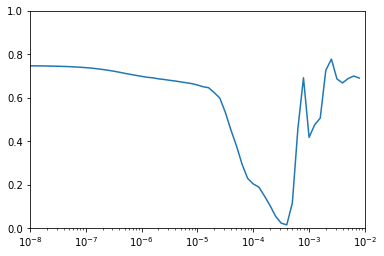

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 1])
gc.collect()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5),
                loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(frames, train_vid_label, batch_size = 4, epochs = 100, validation_split = 0.2)

Epoch 1/100
22/24 [==========================>...] - ETA: 2s - loss: 9.2619 - accuracy: 0.4205

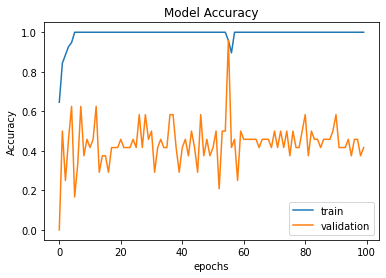

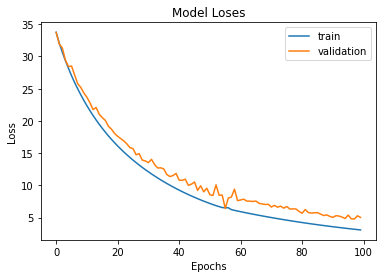

22843

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc = 'lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

gc.collect()

In [ ]:
s = time.time()

test_vid_names = []
test_vid_label = []

test_csv = open('/content/drive/MyDrive/nnfl/assign2/test.csv')
reader = csv.DictReader(test_csv)

for row in reader:
  test_vid_names.append(row['File'])
    
test_csv.close()
test_vid_label = np.array(test_vid_label)
e = time.time()
print(e-s)
gc.collect()

0.00405430793762207


306

In [ ]:
frames_t = np.zeros((len(test_vid_names), max_frames, frame_size[0], frame_size[1], 3), dtype=np.float32)
frame_count_t = []
test_folder = '/content/drive/MyDrive/nnfl/assign2/test/'

print(sys.getsizeof(frames))
gc.collect()

s = time.time()

for i in tqdm(range(len(test_vid_names))):
    
    vid = cv2.VideoCapture(test_folder+test_vid_names[i])
    
    
    # Load full video in temp
    temp = [] 
    ret, frame = vid.read()
    while ret:
        temp.append(cv2.resize(frame,frame_size))
        ret, frame = vid.read()
     
    length = len(temp)
    
    if length < max_frames:
        
        pads_required = max_frames % length
        each_frame_multiplicity = max_frames // length
        for _ in range(len(temp)):
            for __ in range(each_frame_multiplicity):
                frames_t[i][pads_required + _*each_frame_multiplicity + __] = temp[_]
    else:
        
        jump = length / max_frames
        for _ in range(max_frames):
            frames_t[i][_] = temp[int(_*jump)]
    # print(i)
    frame_count_t.append(frames[i].shape)
    gc.collect()

e = time.time()
print(e-s)

gc.collect()

2359296160


  0%|          | 0/20 [00:00<?, ?it/s]

14.706251621246338


0

In [ ]:
s = time.time()
output = model.predict(frames_t)
e = time.time()
print(e-s)

test_vid_label = []
for i in output:
    test_vid_label.append('fire' if i[0]>0.5 else 'not_fire')

2.9528274536132812


In [ ]:
! touch Submission.csv

open('Submission.csv', 'w').close()

output = open('Submission.csv', 'w')

header = ['File', 'Label']
writer = csv.writer(output)
writer.writerow(header)

for i in range(len(test_vid_names)):
    writer.writerow([test_vid_names[i],test_vid_label[i]])

output.close()